<div class="markdown-google-sans">
  <h1>Introduction to Convolutional Neural Network</h2>
</div>

Content:
1. Writing a convolutional layer from scratch
2. Implementing a CNN in torch
3. Loading a pre-trained model
4. Training on GPU

In [ ]:
# ==== Environment Setup ====
# Detects Colab vs local and provides cross-platform utilities

import os
import sys

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✓ Running on Google Colab")
else:
    print("✓ Running locally")

def download_file(url: str, filename: str) -> str:
    """Download file if it doesn't exist. Works on both Colab and local."""
    if os.path.exists(filename):
        print(f"✓ {filename} already exists")
        return filename
    
    print(f"Downloading {filename}...")
    if IN_COLAB:
        import subprocess
        subprocess.run(['wget', '-q', url, '-O', filename], check=True)
    else:
        import urllib.request
        urllib.request.urlretrieve(url, filename)
    print(f"✓ Downloaded {filename}")
    return filename

In [ ]:
# ==== Device Setup ====
import torch

def get_device():
    """Get best available device: CUDA > MPS > CPU."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ Using Apple MPS (Metal)")
    else:
        device = torch.device('cpu')
        print("✓ Using CPU")
    return device

DEVICE = get_device()

# Loading the data

Again, we will be using PyTorch library/framework and a picture database.

In [ ]:
# import basic libs
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
import time
import datetime

# import torch (whole lib & specific modules)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.set_default_dtype(torch.double)

seed = 42

In [ ]:
# import dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split


# change dataset because we want to used RGB pictures
training_data = datasets.CIFAR10( # CIFAR for image classification (10 categories)
    root="data", # specifies directory
    train=True,
    download=True,
    transform=ToTensor(), # converts images from PIL format (or numpy array) to PyTorch Tensor (fundamental data structure for PyTorch)
)

test_data = datasets.training_data = datasets.CIFAR10(
    root="data",
    train=False, # NB
    download=True,
    transform=ToTensor(),
)

#keep only 1/10 of the data
training_data, _ = random_split(training_data, # arg: original dataset to split
                                [1/10, 9/10], # split props
                                generator=torch.manual_seed(seed)) # reproducibility

test_data, _ = random_split(test_data, [1/10, 9/10], generator=torch.manual_seed(seed))

100%|██████████| 170M/170M [00:04<00:00, 41.9MB/s]


In [ ]:
next(iter(training_data))[1] # checking labels - iter()/next() approach is useful when training_data is an iterator or generator that doesn't support direct indexing

6

# Constructing a convolutional layer

We write a convolutional layer from scratch that has all elements discussed in class:
- It handles multiple `out_channels` by creating one filter per channel
- It handles multiple `in_channels` by summing over them
- It applies a convolutional kernel as the cross-correlation between weights and input.


In [ ]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.in_channels = in_channels # the colors (3 RGB)
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride # the gap between slided kernels
        self.padding = padding

        # Initialize weights and bias
        # Weight shape: (out_channels, in_channels, kH, kW)
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))

        # option of adding a learnable bias
        if bias:
          self.bias = nn.Parameter(torch.randn(out_channels))
        else:
          self.bias = torch.zeros(out_channels, requires_grad=False)


    def sum_in_channels(self,
                        x_b, # one picture (colored)
                        c_out):  # the output channel
      """Given an output channel, apply conv kernel over
      all input channels separately and sum them up. """

      # x_b shape: (C_in, H, W) -> a 3d tensor, i.e. picture with R,G,B channels
      out_list = []

      # if only one channel, no need to sum over them
      # if self.in_channels == 1:
      #   out_b = self.apply_conv_kernel(x_b[0], c_in=c_in, c_out=c_out)
      #   return out_b

      # else: output is the sum of the convolutions over all inp channels
      for c_in in range(self.in_channels):
        out_bc = self.apply_conv_kernel(x_b[c_in], c_in=c_in, c_out=c_out)
        out_list.append(out_bc)
      out_b = sum(out_list)

      return out_b


    def apply_conv_kernel(self,
                          x_bc,   # the picture (only 1 color)
                          c_in,   # the input channel
                          c_out): # the output channel
        """Here is where the convolution between a 2dim matrix and a 2dim kernel
        of kernel_size happens, for a given input and output channel.
        Note that here we apply cross-convolution of the weight matrix.
        """

        # x_bc shape: (H, W) -> a 2d matrix, i.e. picture with one color
        H, W = x_bc.shape
        # Calculate output dimensions
        out_H = (H + 2*self.padding - self.kernel_size)//self.stride + 1
        out_W = (W + 2*self.padding - self.kernel_size)//self.stride + 1
        # Initialize the output with the correct dimensions
        out_bc = torch.zeros((out_H, out_W))

        for i in range(out_H):
              for j in range(out_W):
                  # Compute the region to apply the kernel
                  h_start = i * self.stride
                  h_end = h_start + self.kernel_size
                  w_start = j * self.stride
                  w_end = w_start + self.kernel_size
                  # Multiply-accumulate over all input channels
                  region = x_bc[h_start:h_end, w_start:w_end]
                  out_bc[i, j] = torch.sum(region * self.weight[c_out, c_in]) + self.bias[c_out]

        # output is a (smaller) 2d matrix
        return out_bc



    def forward(self, x):
      """This steps brings everything together:
      iterates over each picture in the batch; for each
      of the output channels, applies the convolutional
      kernel to each of the input channels of the picture
      and the input channels.

      The output will have dimension [batch_size, out_channel, out_H, out_W],
      where the last 2 dims depend on stride, padding, kernel_size and img size
      """

      # makes sure that the input is batched
      if x.dim() < 4:
        x = x.unsqueeze(0)  # shape becomes (1, C, H, W)
      # x shape: (batch_size, in_channels, H, W)
      batch_size, in_channels, H, W = x.shape

      # Apply padding if needed
      if self.padding > 0:
          x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

      # Initialize output list
      out_list = []

      # Apply conv layer for each picture in the batch individually
      for b in range(batch_size):
          x_b = x[b] # one picture
          out_b_list = []
          for c_out in range(self.out_channels):
            out_bc = self.sum_in_channels(x_b, c_out=c_out)
            out_b_list.append(out_bc)
          out_b = torch.stack(out_b_list)
          out_list.append(out_b)

      # Final output has dimensions
      out = torch.stack(out_list)

      return out


## Let's test if the class works using the example from the class.
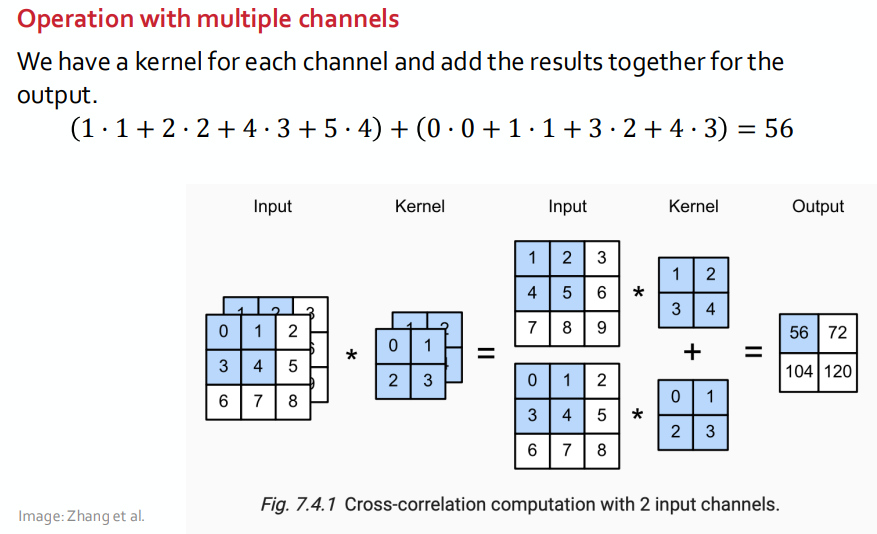

In [ ]:
my_conv = ConvLayer(in_channels=2, out_channels=1, kernel_size=2, bias=False)
conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=2, bias=False)
x = torch.tensor([[[[0,1,2],[3,4,5],[6,7,8]],[[1,2,3],[4,5,6],[7,8,9]]]], dtype=float)


# Initialize weights as in example in class
# weight = nn.Parameter(torch.tensor([[[[0,1],[2,3]], [[1,2],[3,4]]],[[[0,1],[2,3]], [[1,2],[3,4]]]], dtype=float, requires_grad=True))
weight = nn.Parameter(torch.tensor([[[[0,1],[2,3]], [[1,2],[3,4]]]], dtype=float, requires_grad=True))
conv.weight = weight
my_conv.weight = conv.weight


print((my_conv(x) == conv(x)).all())
print(my_conv(x))

tensor(True)
tensor([[[[ 56.,  72.],
          [104., 120.]]]], grad_fn=<StackBackward0>)


# Constructing a convolutional neuronal network using a generic class

We build on the lazy sequential model from last week by adding CNN layers to process our image

In [ ]:
class LazyCNN(nn.Sequential):

    def __init__(self,
                 kernel_spec: list[tuple],
                 activation_fn: str ='ReLU'):

        """
        The input is a list of tuples of type (kernel_size, out_channels) for each conv layer.

        NB: two step function:
            1) first we build a list object called 'layers' that contains definition of layer-wise achitecture as iterable tuples
            2) only then we do call constructor method of the parent class, feeding it the 'layers' list object

        """
        layers = []

        # add the conv layers
        for j, (kernel_size, out_channels) in enumerate(kernel_spec):
          layers.extend([
            nn.Conv2d(in_channels=3 if j==0 else kernel_spec[j-1][-1],
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)])

        layers.extend([

        nn.Flatten(),  # Flatten before fully connected layer
        # Fully connected layer
        nn.LazyLinear(64),  # calling lazy linear if we don't know the inp size
        nn.ReLU(),
        nn.Linear(64, 10)  # 10 classes because CIFAR-10
        ])

        super().__init__(*layers) # the * is the unpacking operator

In [ ]:
# define the training function

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

# NB: getattr gets attribute (fn/class/method) from object; syntax (object, attribute_str)

def torch_train(model,
                data,
                optimizer='Adam',
                loss='CrossEntropyLoss', # classification
                batch_size=2**6,
                epochs=1,
                shuffle=False,
                logdir=None): # for tensorboard


  criterion = getattr(nn, loss)() # returns torch's CrossEntropyLoss() fn

  optimizer = getattr(optim, optimizer)(model.parameters()) # returns 'Adam'() optimiser from torch.optim lib -> passes the parameter attr of the model

  dataloader = DataLoader(data, # wraps our Dataset object in a dataloader
                          batch_size=batch_size,
                          shuffle=shuffle)

  model.train()

  # unique dir path for each training run
  current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  logdir = '//'.join(['runs', current_time, 'train']) if logdir is None else logdir

  # SummaryWriter object (Torch class) for capturing data to be passed to TensorBoard
  logger = SummaryWriter(logdir) # constructor takes str of dir to write events to

  for epoch in range(epochs):
    # init values:
    i = 0

    for (X, Y) in tqdm(dataloader):
        optimizer.zero_grad()
        # Forward pass
        pred = model(X)
        loss = criterion(
            pred.squeeze(-1), # removes a dim -> passes to loss fn
            Y.long()) # ensure Y is a long tensor for CrossEntropyLoss
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        i+=1 # as python starts 0

        # here log training loss fed to TensorBoard
        logger.add_scalar(tag='Training loss per batch', # --> name of scalar point added
                          scalar_value=loss, # --> y (value of the loss)
                          global_step=i + len(dataloader) * epoch) # --> x (batch number)

  return model






In [ ]:
lazy_cnn = LazyCNN([(3,16),(3,32)])
lazy_cnn = torch_train(lazy_cnn, training_data)

100%|██████████| 79/79 [00:04<00:00, 18.84it/s]


In [ ]:
for name, param in lazy_cnn.named_parameters():
  print(name, param.shape)

0.weight torch.Size([16, 3, 3, 3])
0.bias torch.Size([16])
3.weight torch.Size([32, 16, 3, 3])
3.bias torch.Size([32])
7.weight torch.Size([64, 1152])
7.bias torch.Size([64])
9.weight torch.Size([10, 64])
9.bias torch.Size([10])


# Train with GPU

Graphical Processing Units (GPUs) are powerful for training NNs, because they have thousands of smaller cores optimized for parallel workloads - differently from CPUs which have larger and more powerful cores, but fewer.

To train in `torch` using GPU, we have to move both the model and the data to the selected GPU.

In [ ]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(torch.cuda.current_device()))  # prints the name of current GPU

# where is the model rn?
print("model weights are on:", next(iter(lazy_cnn.parameters())).device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lazy_cnn = lazy_cnn.to(device)

Tesla T4
model weights are on: cuda:0


In [ ]:
x, y = next(iter(training_data))
lazy_cnn(x.to(device)) # this won't work, because data and model are on two different devices

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x36 and 1152x64)

In [ ]:
class GPUDataset(Dataset):
  """This class is a wrapper to move items
  in an existing Dataset to a device"""

  def __init__(self, dataset, device):
    self.dataset = dataset
    self.device = device

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    X, y = self.dataset[idx]
    X = X.to(device) if type(X) == torch.Tensor else X
    y = y.to(device) if type(y) == torch.Tensor else y
    return X, y


In [ ]:
gpu_training_data = GPUDataset(training_data, device)
x, y = next(iter(gpu_training_data))
lazy_cnn(x)

tensor([[ 0.1554,  0.0720,  0.0128, -0.0643,  0.0029,  0.0178,  0.0394,  0.1086,
         -0.0964,  0.0066],
        [ 0.1592,  0.1094,  0.0096, -0.0491,  0.0254,  0.0246,  0.0281,  0.1190,
         -0.1277, -0.0082],
        [ 0.1606,  0.1479,  0.0532, -0.0672,  0.0540,  0.0293,  0.0030,  0.0826,
         -0.1698, -0.0513],
        [ 0.1668,  0.1223,  0.0189, -0.0668,  0.0446,  0.0322,  0.0165,  0.0905,
         -0.1412, -0.0440],
        [ 0.1568,  0.1255,  0.0426, -0.0804,  0.0601,  0.0196, -0.0022,  0.0801,
         -0.1501, -0.0384],
        [ 0.1596,  0.0701,  0.0112, -0.0636,  0.0009,  0.0184,  0.0441,  0.1159,
         -0.0948,  0.0087],
        [ 0.1610,  0.0847,  0.0045, -0.0602,  0.0137,  0.0158,  0.0390,  0.1216,
         -0.1111,  0.0019],
        [ 0.1503,  0.1790,  0.0597, -0.0547,  0.0656,  0.0256, -0.0037,  0.0665,
         -0.2038, -0.0734],
        [ 0.1651,  0.0744,  0.0035, -0.0588, -0.0032,  0.0191,  0.0441,  0.1188,
         -0.0969,  0.0042],
        [ 0.1605,  

# Load pretrained models



## Using Torch


In [ ]:
from torchvision.models import resnet18

resnet = resnet18()
# change the model head to adapt to the number of features
resnet.fc = nn.Linear(resnet.fc.in_features, out_features=10)


In [ ]:
for name, param in resnet.named_parameters():
  print(name, param.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

## Using HuggingFace

In [ ]:
%pip install transformers -q

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_name = "google/vit-base-patch16-224-in21k"  # Vision Transformer
processor = AutoImageProcessor.from_pretrained(model_name)
vit = AutoModelForImageClassification.from_pretrained(model_name, num_labels=10)  # CIFAR-10 has 10 classes

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluate the average accuracy of the models

In [ ]:
def evaluate_accuracy(model, test_data):
  """The function evaluates the (multiclass) accuracy of the model"""

  dataloader = DataLoader(test_data, batch_size=len(test_data))
  X_test, Y_test = next(iter(dataloader))
  pred = model(X_test)
  Y_pred = pred.argmax(dim=-1)
  avg_acc =(Y_test == Y_pred).to(float).mean()

  return avg_acc

avg_acc_lazy = evaluate_accuracy(lazy_cnn, test_data)
avg_acc_resnet = evaluate_accuracy(resnet, test_data)
avg_acc_tf = evaluate_accuracy(vit, test_data)

ValueError: Input image size (32*32) doesn't match model (224*224).